In [3]:
from MLForecastPipeline import *

In [4]:
RUN_NUM = 'run_15'

In [5]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
            "12M_train":  {"train_start": "2018-06-01", "train_end": "2019-06-01"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LAG_TRANSFORMS_MAP = {
    "expanding_mean_rolling_14_rolling_30": {1: 'expanding_mean', 7: 'expanding_mean', 30: 'rolling_mean_30'},
    "expanding_mean_rolling_14": {1: 'expanding_mean', 7: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_rolling_30_expanding": {1: 'rolling_mean_14', 7: 'rolling_mean_30', 30: 'expanding_mean'},
    "rolling_14_expanding": {1: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_only": {1: 'rolling_mean_14'},
    "no_transform": {},
}

def map_lag_transforms(lag_transform_dict, lag_transforms_map=LAG_TRANSFORMS_MAP):
    for name, transform in lag_transforms_map.items():
        if lag_transform_dict == transform:
            return name
    return "unknown"

def analyze_results(df, lag_transforms_map=LAG_TRANSFORMS_MAP, mape_threshold=40, model_filter=None):
    df = df.copy()
    df['Lag Transform Name'] = df['Lag Transforms'].apply(lambda x: map_lag_transforms(x, lag_transforms_map))
    df['Lag_Set_Name'] = df['Lag Name']
    # Identify MAPE columns dynamically
    mape_columns = [col for col in df.columns if col.startswith("test_") and col.endswith("_days")]
    
    # Compute mean MAPE across all test periods
    df['MAPE'] = df[mape_columns].mean(axis=1)
    
    # Apply filtering
    top_df = df[df["MAPE"] < mape_threshold].copy()
    if model_filter:
        top_df = top_df[top_df['Model'] == model_filter].copy()
    
    # Compute groupings
    top_models = top_df.groupby("Model")["MAPE"].mean().sort_values().reset_index()
    top_transforms = top_df.groupby("Transforms")["MAPE"].mean().sort_values().reset_index()
    top_lag_transforms = top_df.groupby("Lag Transform Name")["MAPE"].mean().sort_values().reset_index()
    top_lags = top_df.groupby("Lag_Set_Name")["MAPE"].mean().sort_values().reset_index()
    
    # Compute MAPE trends over different forecasting horizons
    mape_trends = top_df.groupby("Model")[mape_columns].mean().reset_index()
    
    return top_models, top_transforms, top_lag_transforms, top_lags, mape_trends

def plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_models["Model"], y=top_models["MAPE"], palette="viridis", hue=top_models["Model"])
    plt.xticks(rotation=45)
    plt.title("Average MAPE per Model")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_transforms["Transforms"], y=top_transforms["MAPE"], palette="coolwarm", hue=top_transforms["Transforms"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lag_transforms["Lag Transform Name"], y=top_lag_transforms["MAPE"], palette="Blues", hue=top_lag_transforms["Lag Transform Name"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Lag Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lags["Lag_Set_Name"], y=top_lags["MAPE"], palette="Blues", hue=top_lags["Lag_Set_Name"])
    plt.xticks(rotation=90)
    plt.title("MAPE vs Number of Lags")
    plt.show()
    
    # Plot MAPE trends across different forecasting horizons
    plt.figure(figsize=(12, 5))
    for model in mape_trends["Model"]:
        plt.plot(mape_trends.columns[1:], mape_trends[mape_trends["Model"] == model].values[0][1:], label=model)
    plt.xlabel("Forecasting Horizon (Days)")
    plt.ylabel("MAPE")
    plt.title("MAPE Trends Across Forecast Horizons")
    plt.legend()
    plt.show()

# Example usage:
# top_models, top_transforms, top_lag_transforms, top_lags, mape_trends = analyze_results(df, lag_transforms_map, optimal_lags_map)
# plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends)


In [7]:
import glob
results = {}
for file in glob.glob(f"results/{RUN_NUM}/*.csv"):
    dataset_name = file.split("\\")[-1].replace(".csv", "")
    try:
        results[dataset_name] = pd.read_csv(file)
    except Exception as e:
        print(e)        

In [8]:
import re

def extract_train_info(dataset_name):
    """
    Extracts sensor ID, training length in months, and a standardized train label.
    
    Example Inputs:
        - "6_NH_15D_train"  → (6, 0.5, "NH_15D_train")
        - "6_H_5M_train"    → (6, 5, "H_5M_train")
        - "2_18M_train"     → (2, 18, "18M_train")
    
    Returns:
        - sensor (int): Sensor ID
        - train_months (float): Training length in months
        - train_label (str): Everything after the sensor ID (used for finding comparable datasets)
    """
    name_parts = dataset_name.split('_')

    # Extract sensor ID
    sensor = int(name_parts[0])  # First part is always the sensor number

    # Reconstruct the label for easy dataset comparison
    train_label = '_'.join(name_parts[1:])

    # Extract training length (2nd to last part contains number + unit)
    train_info = name_parts[-2]  # Example: "15D" or "5M"
    match = re.match(r"(\d+)([MD])", train_info)  # Extract number and unit

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)

        # Convert days to months (approximate)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  # Invalid format, return None values

    return sensor, train_months, train_label

# Example Usage
datasets = ["6_NH_15D_train", "6_H_5M_train", "2_18M_train"]
for ds in datasets:
    print(f"{ds} → {extract_train_info(ds)}")


6_NH_15D_train → (6, 0.5, 'NH_15D_train')
6_H_5M_train → (6, 5, 'H_5M_train')
2_18M_train → (2, 18, '18M_train')


In [9]:
import re
import pandas as pd
import numpy as np
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Define function mapping
lag_transforms_mapping = {
    'expanding_mean': expanding_mean,
    'rolling_mean_14': rolling_mean_14,
    'rolling_mean_30': rolling_mean_30,
}

# Function to convert lag_transforms dictionary to a string
def stringify_lag_transforms(lag_transforms):
    """Converts lag_transforms dictionary to a clean string format for storage."""
    return str({key: [func.__name__ for func in funcs] for key, funcs in lag_transforms.items()})

# Function to parse lag_transforms safely from an invalid dictionary-like string
def parse_lag_transforms(lag_transforms_str):
    """Parses a raw function dictionary string and converts it back to a proper dictionary with function references."""
    try:
        # Extract function names using regex pattern: `<function function_name at 0x...>`
        cleaned_str = re.sub(r'<function (\w+) at 0x[0-9A-Fa-f]+>', r'"\1"', lag_transforms_str)

        # Convert cleaned string into a valid Python dictionary
        temp_dict = eval(cleaned_str)  # Evaluates after function names are fixed

        # Map function names back to actual function references
        return {key: [lag_transforms_mapping[func_name] for func_name in funcs] for key, funcs in temp_dict.items()}
    
    except Exception as e:
        # print(f"Error parsing lag_transforms {lag_transforms_str}: {e}")
        return 1
    
from mlforecast.lag_transforms import *

lag_transform_mapping = {
    'RollingMean': RollingMean,
    'ExpandingMean': ExpandingMean,
    'ExponentiallyWeightedMean': ExponentiallyWeightedMean,
}
def create_lag_transform_object(transform_str):
    """Creates a lag transform object from a string representation."""
    class_name = transform_str.split('(')[0].strip()
    params_str = transform_str[transform_str.find('(') + 1:transform_str.find(')')] if '(' in transform_str else None
    params = {}
    if params_str:
        for param in params_str.split(','):
            key, value = param.split('=')
            params[key.strip()] = int(value.strip())  # Assuming numerical parameters

    if class_name in lag_transform_mapping:
        return lag_transform_mapping[class_name](**params) if params else lag_transform_mapping[class_name]()
    else:
        raise ValueError(f"Unknown lag transform: {class_name}")

from collections import defaultdict
def parse_lag_transforms_mlfcst(initial_lag_transforms_str):
    """Parses the string representation of lag transforms into a dictionary."""
    lag_transforms = defaultdict(list)  # Use defaultdict for easier handling
    if isinstance(initial_lag_transforms_str, str):
        try:
            # Split the string into individual lag and transform groups
            transform_groups = initial_lag_transforms_str.strip("{}").split(", ")

            for group in transform_groups:
                lag_str, transform_strs_list = group.split(": ")
                lag = int(lag_str)

                # Remove brackets and split the transform strings
                transform_strs = transform_strs_list.strip("[]").split(", ")

                for transform_str in transform_strs:
                    # Clean the transform string (remove quotes and any extra spaces)
                    clean_transform_str = transform_str.strip().strip("'")

                    # Create transform object and append to the list
                    transform_object = create_lag_transform_object(clean_transform_str)
                    lag_transforms[lag].append(transform_object)

        except ValueError as e:
            print(f"Error parsing lag transforms string: {e}")
            return {}  # Or raise the exception

    return dict(lag_transforms)

def get_lag_transforms(lag_transform_str):
    lag_transforms = parse_lag_transforms(lag_transform_str)
    if lag_transforms == 1:
        return parse_lag_transforms_mlfcst(lag_transform_str)
    return lag_transforms

# Example input with incorrect function references
initial_lag_transforms_str = "{1: [<function expanding_mean at 0x0000021CAC0F2840>], 7: [<function rolling_mean_14 at 0x0000021CA47C3C40>], 30: [<function expanding_mean at 0x0000021CAC0F2840>]}"

# Convert to proper lag_transforms dictionary
parsed_lag_transforms = get_lag_transforms(initial_lag_transforms_str)

print("String Input:", initial_lag_transforms_str)
print("Parsed Back:", parsed_lag_transforms)


String Input: {1: [<function expanding_mean at 0x0000021CAC0F2840>], 7: [<function rolling_mean_14 at 0x0000021CA47C3C40>], 30: [<function expanding_mean at 0x0000021CAC0F2840>]}
Parsed Back: {1: [<function expanding_mean at 0x0000024C6B2D0040>], 7: [<function rolling_mean_14 at 0x0000024C7CD7F420>], 30: [<function expanding_mean at 0x0000024C6B2D0040>]}


In [10]:
initial_lag_transforms_str = "{7: [RollingMean(window_size=7)], 30: [RollingMean(window_size=30)], 60: [RollingMean(window_size=60)]}"
get_lag_transforms(initial_lag_transforms_str)

{7: [RollingMean(window_size=7)],
 30: [RollingMean(window_size=30)],
 60: [RollingMean(window_size=60)]}

In [11]:
import pandas as pd
import numpy as np
import re
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
# from my_custom_utils import format_df_to_mlforecast, split_data  # Assuming these are in a module
import ast

# Define parameters


# Define available lag transforms
lag_transforms_options = [
    {1: [expanding_mean], 7: [rolling_mean], 30: [expanding_mean]},
    {1: [rolling_mean], 7: [rolling_mean], 30: [expanding_mean]},
]

model_mapping = {
    "XGBRegressor": XGBRegressor(),
    "SGDRegressor_42": SGDRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SGD_EarlyStopping": SGDRegressor( random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=7, tol=1e-4 ),
    "SGD_ElasticNet": SGDRegressor( penalty='elasticnet', l1_ratio=0.5, alpha=0.001, random_state=42 ),
    "SGD_Lasso": SGDRegressor( penalty='l1', alpha=1, random_state=42 ),
    "SGD_Ridge": SGDRegressor( penalty='l2', alpha=1, random_state=42 ),
    "SGDRegressor": SGDRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor(),
}

transform_mapping = {
    "AutoDifferences" : AutoDifferences, 
    "AutoSeasonalDifferences" : AutoSeasonalDifferences, 
    "AutoSeasonalityAndDifferences" : AutoSeasonalityAndDifferences,
    "LocalStandardScaler" : LocalStandardScaler, 
    "LocalMinMaxScaler" : LocalMinMaxScaler, 
    "LocalBoxCox" : LocalBoxCox
}

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Function to extract sensor ID and train length
def extract_train_info(dataset_name):
    name_parts = dataset_name.split('_')
    sensor = int(name_parts[0])  
    train_label = '_'.join(name_parts[1:])

    train_info = name_parts[-2]  
    match = re.match(r"(\d+)([MD])", train_info)  

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  

    return sensor, train_months, train_label

# Function to reverse `stringify_transform`
def parse_transform_string(transform_str):
    transform_str = transform_str.strip()
    if "(" in transform_str:
        class_name, params = transform_str.split("(", 1)
        params = params.rstrip(")")
        param_dict = {}
        if params != "NoParams" and class_name != "LocalBoxCox":
            for param in params.split(", "):
                key, value = param.split("=")
                if key in ("max_diffs", "season_length", "max_season_length"):
                    param_dict[key] = int(value) if value.replace(".", "").isdigit() else value
        return class_name, param_dict
    return transform_str, {}

In [12]:
# Define patterns to match and their correct format
rename_patterns = {
    "H_3M_jul_train": "H_jul_3M_train",
    "H_3M_sep_train": "H_sep_3M_train",
    "H_3M_nov_train": "H_nov_3M_train",
}

# Create a new dictionary with updated keys
updated_results = {}

for dataset_name, df in results.items():
    new_name = dataset_name  # Default: keep the same name

    for old_pattern, new_pattern in rename_patterns.items():
        if old_pattern in dataset_name:
            new_name = dataset_name.replace(old_pattern, new_pattern)
            break  # Stop checking once renamed

    updated_results[new_name] = df  # Preserve the dataset content

results = updated_results

In [13]:
import warnings
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [14]:
from datetime import datetime
from collections import defaultdict

def calculate_monthly_mape(predictions_df, date_col='ds', actual_col='y', forecast_col='forecast', id_col='unique_id'):
    """
    Calculate MAPE (Mean Absolute Percentage Error) for each month-year in the predictions dataframe.
    
    Returns:
    --------
    dict
        Dictionary with keys as 'month_year' (e.g., 'Jan_2019') and values as MAPE for that month
    dict
        Dictionary with keys as 'month_year' and values as sample counts for that month
    pandas.DataFrame
        DataFrame with detailed MAPE information by month-year and entity
    dict
        Dictionary with keys as (year, month) tuples and values as MAPE for that year and month
    """
    # Ensure the date column is datetime
    df = predictions_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col])
    
    # Create month-year column for string representation
    df['month_year'] = df[date_col].dt.strftime('%b_%Y')
    
    # Create separate year and month columns
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month  # Numeric month (1-12)
    df['month_name'] = df[date_col].dt.strftime('%b')  # Month abbreviation
    
    # Calculate absolute percentage error for each row
    df['abs_pct_error'] = np.abs((df[actual_col] - df[forecast_col]) / df[actual_col])
    
    # Replace inf and NaN values (occurs when actual value is 0)
    df['abs_pct_error'] = df['abs_pct_error'].replace([np.inf, -np.inf], np.nan)
    
    # Initialize results dictionaries
    mape_by_month_year = {}  # String format: 'Jan_2019'
    mape_by_year_month = {}  # Tuple format: (2019, 1)
    sample_counts = {}
    
    # Calculate MAPE for each month-year
    for month_year, group in df.groupby('month_year'):
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        mape_by_month_year[month_year] = mape if not pd.isna(mape) else None
        sample_counts[month_year] = len(group)
    
    # Calculate MAPE for each year, month tuple
    for (year, month), group in df.groupby(['year', 'month']):
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        mape_by_year_month[(year, month)] = mape if not pd.isna(mape) else None
    
    # Also calculate MAPE by month-year-entity for detailed analysis
    detailed_results = []
    for (year, month, entity_id), group in df.groupby(['year', 'month', id_col]):
        month_name = group['month_name'].iloc[0]
        month_year = group['month_year'].iloc[0]
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        detailed_results.append({
            'year': year,
            'month': month,
            'month_name': month_name,
            'month_year': month_year,
            'entity_id': entity_id,
            'mape': mape if not pd.isna(mape) else None,
            'sample_count': len(group)
        })
    
    detailed_df = pd.DataFrame(detailed_results)
    
    # Sort the dictionaries by date for easier interpretation
    sorted_month_years = sorted(mape_by_month_year.keys(), 
                               key=lambda x: datetime.strptime(x, '%b_%Y'))
    
    sorted_mape = {month_year: mape_by_month_year[month_year] for month_year in sorted_month_years}
    sorted_counts = {month_year: sample_counts[month_year] for month_year in sorted_month_years}
    
    return sorted_mape, sorted_counts, detailed_df, mape_by_year_month

def get_monthly_aggregated_mape(predictions_df, date_col='ds', actual_col='y', forecast_col='forecast'):
    """
    Calculate MAPE for each month (e.g., January, February) aggregated across all years.
    
    Parameters:
    -----------
    Same as calculate_monthly_mape
        
    Returns:
    --------
    dict
        Dictionary with keys as month names (e.g., 'Jan', 'Feb') and values as MAPE for that month across all years
    """
    # Ensure the date column is datetime
    df = predictions_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col])
    
    # Create month column
    df['month'] = df[date_col].dt.strftime('%b')
    
    # Calculate absolute percentage error for each row
    df['abs_pct_error'] = np.abs((df[actual_col] - df[forecast_col]) / df[actual_col])
    df['abs_pct_error'] = df['abs_pct_error'].replace([np.inf, -np.inf], np.nan)
    
    # Calculate MAPE for each month across all years
    mape_by_month = {}
    for month, group in df.groupby('month'):
        mape = group['abs_pct_error'].mean() * 100
        mape_by_month[month] = mape if not pd.isna(mape) else None
    
    # Sort months in calendar order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sorted_mape = {month: mape_by_month.get(month) for month in month_order if month in mape_by_month}
    
    return sorted_mape

In [15]:
run_threshold_map = {
    'run_12': [30, 30, 30], # no weights new models and lag transforms 
    'run_13': [30, 30, 30], # run_12 + weigths
    # from here saving preds, months, cumulative
    'run_14': [30, 30, 30], # roll 7
    'run_15': [30, 30, 30], # resids from prophet_2_sensor
}

In [59]:
prediction_1_df = pd.read_csv("../data/prophet2_pred.csv", index_col=0)
prediction_1_df['ds']  = prediction_1_df.index

In [60]:
def raw_str_preds_to_list(preds_string_raw):    
    preds_list = []
    if pd.notna(preds_string_raw) and isinstance(preds_string_raw, str):
        # 1. Remove leading/trailing brackets and whitespace
        cleaned_string = preds_string_raw.strip('[]').strip()

        # 2. Replace newline characters (if any) with spaces
        cleaned_string = cleaned_string.replace('\n', ' ')

        # 3. Split the string by spaces. This handles multiple spaces between numbers.
        string_values = cleaned_string.split()

        # 4. Convert each resulting string element to a float
        try:
            preds_list = [float(val) for val in string_values]
            return preds_list
        except ValueError:
            print(f"Warning: Could not convert all elements in '{preds_string_raw}' to float.")
    else:
        print(f"Warning: 'preds' column value is missing or not a string: {preds_string_raw}")
    raise KeyError('nope')

DATASET: 2_12M_train
(1312, 17)
52.563832780155515
{'Jun_2019': 70.82800186956663, 'Jul_2019': 67.59384081164043, 'Aug_2019': 50.89094804450096, 'Sep_2019': 55.23076042035752, 'Oct_2019': 27.256296300527904, 'Nov_2019': 27.267443184745353, 'Dec_2019': 49.3498051219061, 'Jan_2020': 38.263567972131426, 'Feb_2020': 63.70357226079611, 'Mar_2020': 34.15489999630849, 'Apr_2020': 52.04567215896516, 'May_2020': 64.14411426527144, 'Jun_2020': 85.31069828814147, 'Jul_2020': 70.39613066778112, 'Aug_2020': 47.16309687089683, 'Sep_2020': 60.25501349481298, 'Oct_2020': None}


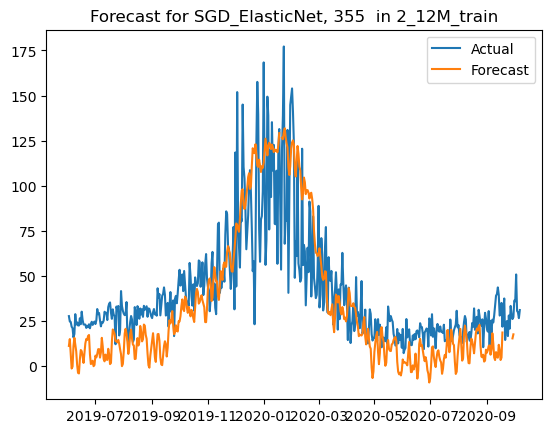

{'Jun_2019': 70.73492592009119, 'Jul_2019': 67.5591087167241, 'Aug_2019': 50.88751672730164, 'Sep_2019': 55.229319186756676, 'Oct_2019': 27.2796051595524, 'Nov_2019': 27.261641800109537, 'Dec_2019': 49.33797072367389, 'Jan_2020': 38.249916415906895, 'Feb_2020': 63.67011241744653, 'Mar_2020': 34.161964650363366, 'Apr_2020': 52.067265764922496, 'May_2020': 64.24617373130474, 'Jun_2020': 85.57015854231426, 'Jul_2020': 70.57735255434446, 'Aug_2020': 47.339345978785836, 'Sep_2020': 60.42409958797498, 'Oct_2020': None}


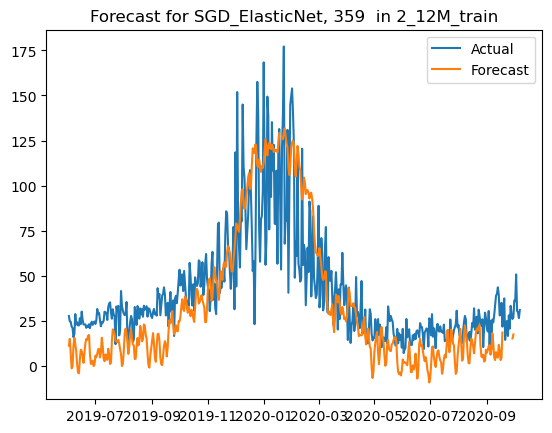

{'Jun_2019': 70.82800186956663, 'Jul_2019': 67.59384081164043, 'Aug_2019': 50.89094804450096, 'Sep_2019': 55.23076042035752, 'Oct_2019': 27.256296300527904, 'Nov_2019': 27.267443184745353, 'Dec_2019': 49.3498051219061, 'Jan_2020': 38.263567972131426, 'Feb_2020': 63.70357226079611, 'Mar_2020': 34.15489999630849, 'Apr_2020': 52.04567215896516, 'May_2020': 64.14411426527144, 'Jun_2020': 85.31069828814147, 'Jul_2020': 70.39613066778112, 'Aug_2020': 47.16309687089683, 'Sep_2020': 60.25501349481298, 'Oct_2020': None}


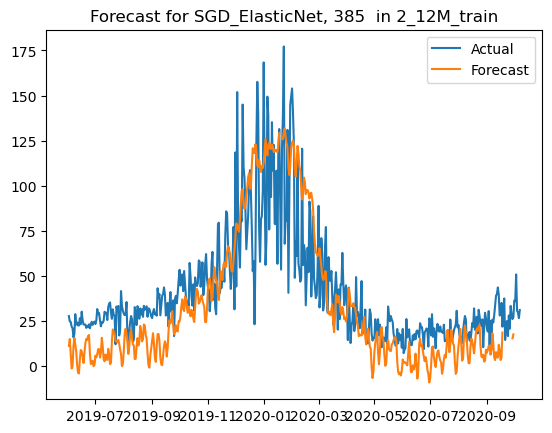

{'Jun_2019': 70.73492592009119, 'Jul_2019': 67.5591087167241, 'Aug_2019': 50.88751672730164, 'Sep_2019': 55.229319186756676, 'Oct_2019': 27.2796051595524, 'Nov_2019': 27.261641800109537, 'Dec_2019': 49.33797072367389, 'Jan_2020': 38.249916415906895, 'Feb_2020': 63.67011241744653, 'Mar_2020': 34.161964650363366, 'Apr_2020': 52.067265764922496, 'May_2020': 64.24617373130474, 'Jun_2020': 85.57015854231426, 'Jul_2020': 70.57735255434446, 'Aug_2020': 47.339345978785836, 'Sep_2020': 60.42409958797498, 'Oct_2020': None}


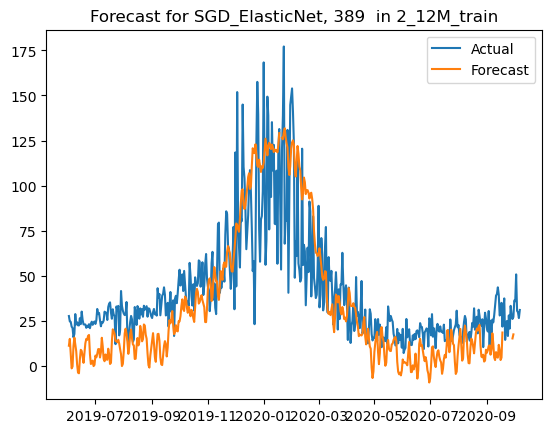

{'Jun_2019': 70.82800186956663, 'Jul_2019': 67.59384081164043, 'Aug_2019': 50.89094804450096, 'Sep_2019': 55.23076042035752, 'Oct_2019': 27.256296300527904, 'Nov_2019': 27.267443184745353, 'Dec_2019': 49.3498051219061, 'Jan_2020': 38.263567972131426, 'Feb_2020': 63.70357226079611, 'Mar_2020': 34.15489999630849, 'Apr_2020': 52.04567215896516, 'May_2020': 64.14411426527144, 'Jun_2020': 85.31069828814147, 'Jul_2020': 70.39613066778112, 'Aug_2020': 47.16309687089683, 'Sep_2020': 60.25501349481298, 'Oct_2020': None}


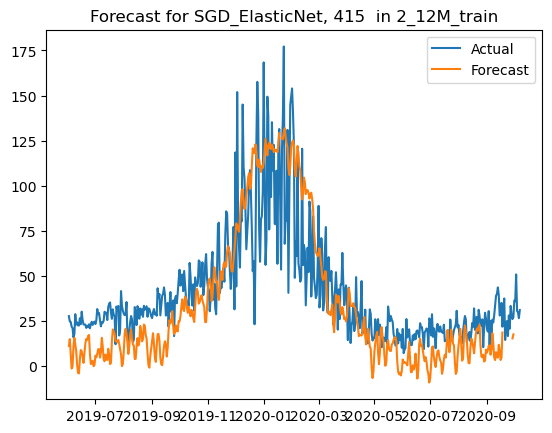

{'Jun_2019': 70.73492592009119, 'Jul_2019': 67.5591087167241, 'Aug_2019': 50.88751672730164, 'Sep_2019': 55.229319186756676, 'Oct_2019': 27.2796051595524, 'Nov_2019': 27.261641800109537, 'Dec_2019': 49.33797072367389, 'Jan_2020': 38.249916415906895, 'Feb_2020': 63.67011241744653, 'Mar_2020': 34.161964650363366, 'Apr_2020': 52.067265764922496, 'May_2020': 64.24617373130474, 'Jun_2020': 85.57015854231426, 'Jul_2020': 70.57735255434446, 'Aug_2020': 47.339345978785836, 'Sep_2020': 60.42409958797498, 'Oct_2020': None}


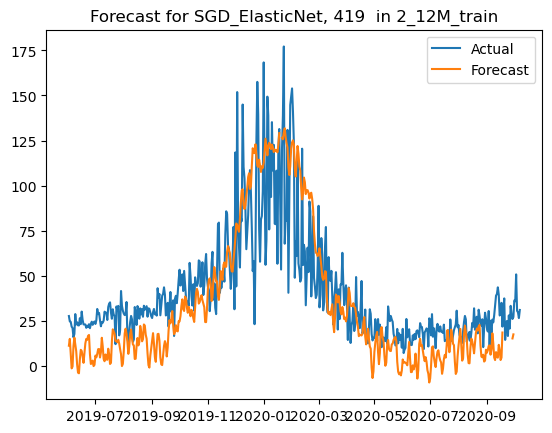

{'Jun_2019': 70.82800186956663, 'Jul_2019': 67.59384081164043, 'Aug_2019': 50.89094804450096, 'Sep_2019': 55.23076042035752, 'Oct_2019': 27.256296300527904, 'Nov_2019': 27.267443184745353, 'Dec_2019': 49.3498051219061, 'Jan_2020': 38.263567972131426, 'Feb_2020': 63.70357226079611, 'Mar_2020': 34.15489999630849, 'Apr_2020': 52.04567215896516, 'May_2020': 64.14411426527144, 'Jun_2020': 85.31069828814147, 'Jul_2020': 70.39613066778112, 'Aug_2020': 47.16309687089683, 'Sep_2020': 60.25501349481298, 'Oct_2020': None}


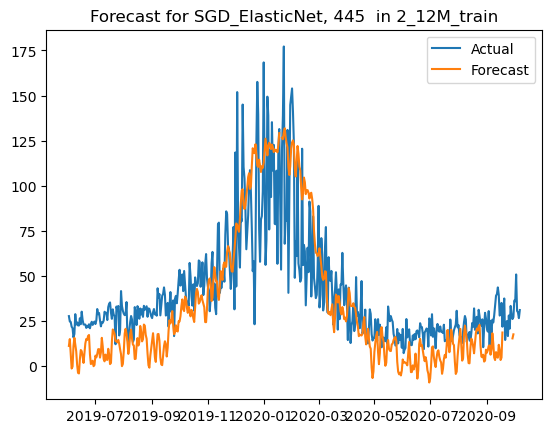

{'Jun_2019': 70.73492592009119, 'Jul_2019': 67.5591087167241, 'Aug_2019': 50.88751672730164, 'Sep_2019': 55.229319186756676, 'Oct_2019': 27.2796051595524, 'Nov_2019': 27.261641800109537, 'Dec_2019': 49.33797072367389, 'Jan_2020': 38.249916415906895, 'Feb_2020': 63.67011241744653, 'Mar_2020': 34.161964650363366, 'Apr_2020': 52.067265764922496, 'May_2020': 64.24617373130474, 'Jun_2020': 85.57015854231426, 'Jul_2020': 70.57735255434446, 'Aug_2020': 47.339345978785836, 'Sep_2020': 60.42409958797498, 'Oct_2020': None}


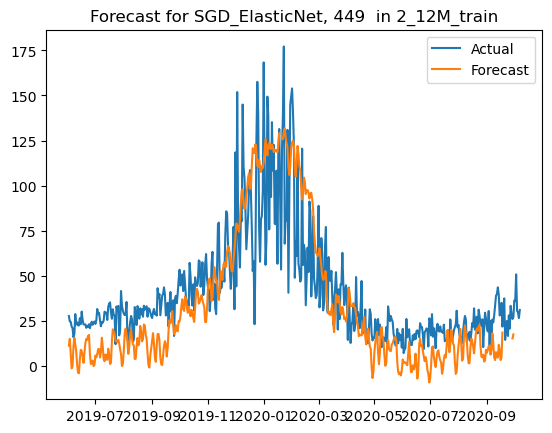

In [66]:
import hashlib
import joblib
import json
import pandas as pd
import os
import ast  # Import ast
from joblib import Parallel, delayed

failed_models_log = f"results_of_results/{RUN_NUM}_failed_models_log.txt"

HORIZONS = [30, 60, 90, 120, 150, 180, 240, 300, 360, 480, 600, 720, 737]
MAPE_COLUMNS = [f"test_{h}_days" for h in HORIZONS]
EARLY_HORIZON_THRESHOLD = 30  # MAPE threshold for early horizons
ONE_THIRD_THRESHOLD = 30       # Threshold for MAPE at 1/3 of training length
ONE_THIRD_THRESHOLD_GENERAL = 30       # Threshold for MAPE at 1/3 of training length
EARLY_HORIZONS = [30, 60, 90, 120]  # Horizons we check for early filtering
SENSORS_TO_COMPARE = [2, 5, 6]  # Sensors that share training length criteria

LONG_TRAIN_FILTER = False

# Ensure directory exists
save_dir = f"results_of_results/{RUN_NUM}"
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Function to create a unique hash based on model parameters
def generate_model_hash(model_name, transforms, lags, lag_transforms):
    """Creates a short unique hash for the model based on its features & transforms."""
    hash_input = f"{model_name}_{transforms}_{lags}_{lag_transforms}"
    return hashlib.md5(hash_input.encode()).hexdigest()[:8]  # Take only the first 8 characters

# Dictionary to store information about passed models
passed_models_info = {}
good_winter_models = []
from mlforecast.lag_transforms import RollingMean, ExpandingMean, ExponentiallyWeightedMean
def process_row(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors, prediction_1_df, C):
    """Processes a single row (model) from the filtered DataFrame."""
    model_name = row["Model"]
    transforms_str = row["Transforms"]
    lags = row["Lags"]
    lag_transforms_str = row["Lag Transforms"]

    # Prepare dataset
    sensor_id = str(sensor_id)
    scenario = scenarios_sensors[sensor_id][train_label]

    if sensor_id not in scenarios_sensors:
        return None  # Skip this model

    formatted_df = format_df_to_mlforecast(
        selected_sensors_df[['full_date', sensor_id]], 'full_date', sensor_id, unique_id=sensor_id
    )
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]
    train_df, test_df = split_data(formatted_df, scenario)

    test_df_copy = test_df.copy()

    prediction_1_df['ds'] = pd.to_datetime(prediction_1_df['ds'])
    test_pred1_df = prediction_1_df[prediction_1_df['ds'] >= test_df_copy['ds'].min()]
    pred2_list = raw_str_preds_to_list(row['preds'])

    test_df_copy['forecast'] = test_pred1_df['y'].values + pred2_list - C

    sorted_mape, sorted_counts, detailed_df, mape_by_year_month = calculate_monthly_mape(test_df_copy)

    winter_months = [1, 2, 3, 10, 11, 12]  # Jan, Feb, Mar, Oct, Nov, Dec
    winter_mape_full = detailed_df[detailed_df['month'].isin(winter_months)]
    mean_winter_mape = winter_mape_full['mape'].mean()
    year_winter_mean_mape = winter_mape_full.groupby('year')['mape'].mean().to_dict()

    if mean_winter_mape < 40:
        plot_data = {
            'test_df_copy': test_df_copy,
            'model_name': model_name,
            'dataset_name': dataset_name
        }
        return {
            'dataset': dataset_name,
            'model_name': model_name,
            'transforms_str': transforms_str,
            'lags': lags,
            'lag_transforms_str': lag_transforms_str,
            'mean_winter_mape': mean_winter_mape,
            **year_winter_mean_mape,
            'sorted_mape': sorted_mape,
            'plot_data': plot_data
        }
    else:
        return None  # Model didn't meet criteria

# Process each dataset
for dataset_name, df in results.items():
# for dataset_name, df in results_left.items():
    print("=" * 80)
    print(f"DATASET: {dataset_name}")
    print("=" * 80)

    sensor_id, train_months, train_label = extract_train_info(dataset_name)
    if sensor_id is None:
        print("Skipping dataset: Cannot determine sensor ID or train length.")
        continue
    if train_months < 10:
        continue
    mape_columns_local = [c for c in MAPE_COLUMNS if c in df.columns]

    # --- (a) Filtering Criteria ---

    # 1. Remove models exceeding the early horizon threshold
    local_early_horizons_threshold = EARLY_HORIZON_THRESHOLD
    local_one_third_thresh = ONE_THIRD_THRESHOLD
    # if train_months <= 12:
    #     local_early_horizons_threshold = 25
    #     local_one_third_thresh = 27
    if LONG_TRAIN_FILTER and train_months >= 24:
        local_early_horizons_threshold = 25
        local_one_third_thresh = 27
    early_horizon_cols = [f"test_{h}_days" for h in EARLY_HORIZONS if f"test_{h}_days" in df.columns]
    mask_early_horizon = (df[early_horizon_cols] <= local_early_horizons_threshold).all(axis=1)

    # 2. Ensure MAPE is good at 1/3 of train length
    one_third_horizon = int(train_months * 30 // 3)
    closest_horizon = min(HORIZONS, key=lambda x: abs(x - one_third_horizon))

    if f"test_{closest_horizon}_days" in df.columns:
        mask_one_third = df[f"test_{closest_horizon}_days"] <= local_one_third_thresh
    else:
        mask_one_third = True

    # Apply filters
    df_filtered = df[mask_early_horizon & mask_one_third].copy()
    print(df_filtered.shape)
    # --- (b) Extract best models and reconstruct `MLForecast` ---
    # Use joblib to parallelize the processing of rows
    from functions import rolling_zscore_outlier_removal

    prediction_1_df['y'] = rolling_zscore_outlier_removal(prediction_1_df['y'], window=300, z_threshold=2)
    epsilon = 0.001
    C = abs(prediction_1_df['y'].min()) + epsilon
    C = 52.563832780155515
    print(C)
    # for _, row in df_filtered.iterrows():
        # process_row(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors, prediction_1_df, C)
    results_list = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(process_row)(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors, prediction_1_df, C)
        for _, row in df_filtered.iterrows()
    )

    # Filter out None results (failed models or models not meeting criteria)
    good_winter_models.extend(r for r in results_list if r is not None)

    for index, result in enumerate(results_list):
        if result and 'plot_data' in result:
            plot_data = result['plot_data']
            test_df_copy = plot_data['test_df_copy']
            model_name = plot_data['model_name']
            dataset_name = plot_data['dataset_name']

            # Generate the plot
            print(result['sorted_mape'])
            plt.figure()  # Create a new figure for each plot
            plt.plot(test_df_copy['ds'], test_df_copy['y'], label='Actual')
            plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label='Forecast')
            plt.title(f"Forecast for {model_name}, {index}  in {dataset_name}")
            plt.legend()
            plt.show()  


# After processing all datasets, convert to DataFrame (optional)
good_winter_models_df = pd.DataFrame(good_winter_models)

In [67]:
good_winter_models_df = pd.DataFrame(good_winter_models)

def calculate_lags_name(lags_str):
    try:
        lags = eval(lags_str) if isinstance(lags_str, str) else lags_str
        return f'{len(lags)}_{max(lags)}'
    except:
        return "Error"  # Handle potential errors, e.g., invalid string
# good_winter_models_df['lags_name'] = good_winter_models_df['lags'].apply(calculate_lags_name)
 
good_winter_models_df

StopIteration: 

StopIteration: 